# LunarLander-v2 DRL Testing Analysis

This notebook thoroughly analyzes the six trained DRL agents for the LunarLander-v2 environment part of the DRL testing framework.

---

#### Goals 
- Display side-by-side comparisons of learning curves across two algorithms (**PPO, A2C**), and three reward-based personas (**Baseline, Speedrunner, Safe Lander**).
- Evaluate learning behaviour, stability, and convergence.
- Compare per-episode metrics across 30 episodes per agent.
- Gather per-episode performance metrics, aggregate data and analyze trends.
- Compare crash/landing rates and trade-offs resulting from different reward-designs (personas).
- Plot learning curves and metric distributions using Matplotlib.
  
---

#### Personas
- **Baseline**: This is Gymnasium's default reward design of LunarLander-v2. It is included to aid in comparison of different reward designs.
- **Speedrunner**: Focuses on landing fast, gets penalized for being too slow and is also more lenient on crashes.
- **Safe Lander**: Focuses on landing smoothly with minimal impact. Takes its time to land, and tries to land accurately.

---
#### Notes
- Each agent was trained for 500,000 timesteps.
- Training used StableBaselines3 with fixed random seeds for reproducibility.

### 1. Import and Setup

In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

### 2. Learning Curves

The easiest way to visualize the overall performance of the agents is by plotting their learning curves.
In this section, we create six total plots. 

- Each plot shows two curves that represent the algorithms (PPO vs. A2C).
- Each plot itself represents a persona: *Baseline*, *Speedrunner*, *Safe Lander*.
- The CSV data used for the plots is based off of the logs for each model, and downloaded as CSV from tensorboard.

The plots below show the learning curves of the ep_rew_mean (mean episode rewards) vs. the total timesteps during training.

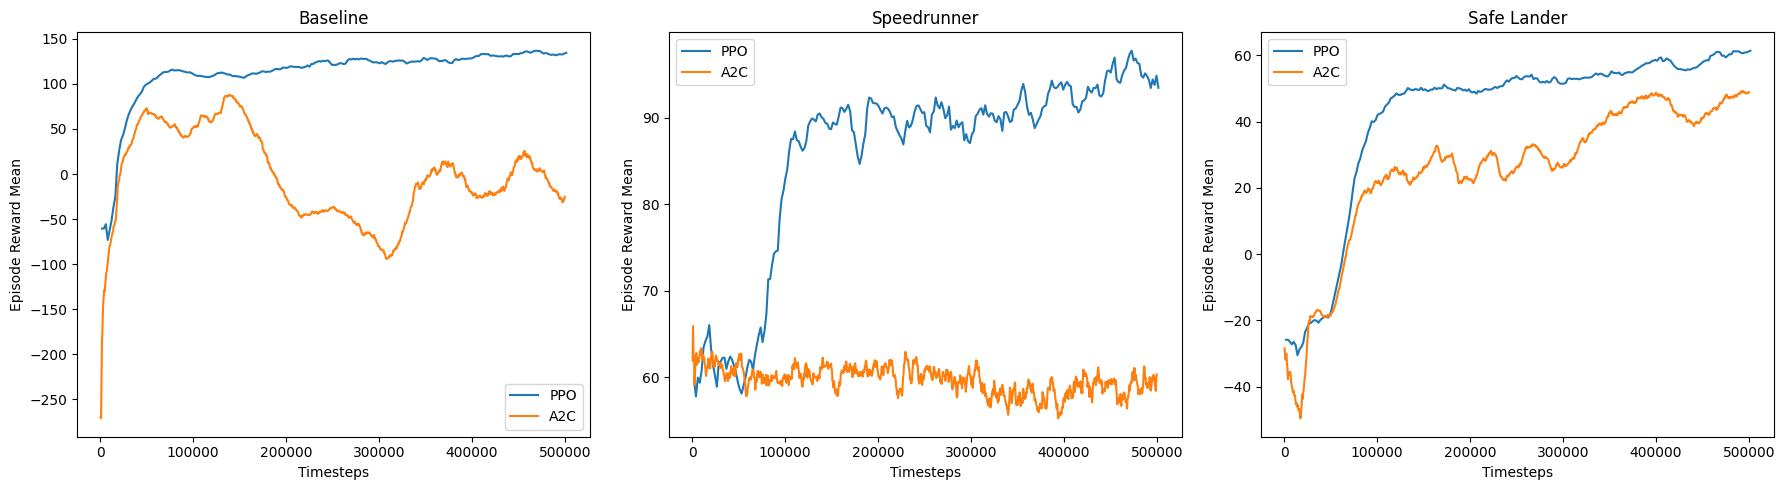

In [15]:
personas = ["baseline", "speedrunner", "safe"]
algos = ["ppo", "a2c"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, persona in enumerate(personas):
    for algo in algos:
        df = pd.read_csv(f"../data/lunar_lander/{algo}_{persona}_ep_rew_mean.csv")
        axes[i].plot(df["Step"], df["Value"], label=algo.upper())

    if persona == "safe": 
        axes[i].set_title("Safe Lander")
    else: 
        axes[i].set_title(persona.capitalize())

    axes[i].set_xlabel("Timesteps")
    axes[i].set_ylabel("Episode Reward Mean")
    axes[i].legend()
    
plt.tight_layout()
plt.show()

#### Analysis of Episode Reward Curves
There are some significant differences in the model performances for each persona.
- For all agents, the PPO versions tend to have a much quicker increase in the reward.
  
- The A2C models initially improve as well, but fail to stay consistent, and fall off at some points.
  
- The overall rewards for all personas seem to be lower than PPO, even though they're both trained in 500,000 timesteps.
  
- For the Speedrunner persona, the A2C model stays flat almost the entire time. This indicates it failed to learn meaningful behaviour. The reward design prioritized speed and strongly penalized longer episode time, so A2C likely plateaued as the rewards and penalties were likely too strong, and it was unable to discover success cases.

Now, let's look at the ep_len_mean (mean episode lengths) vs. total timesteps during training.

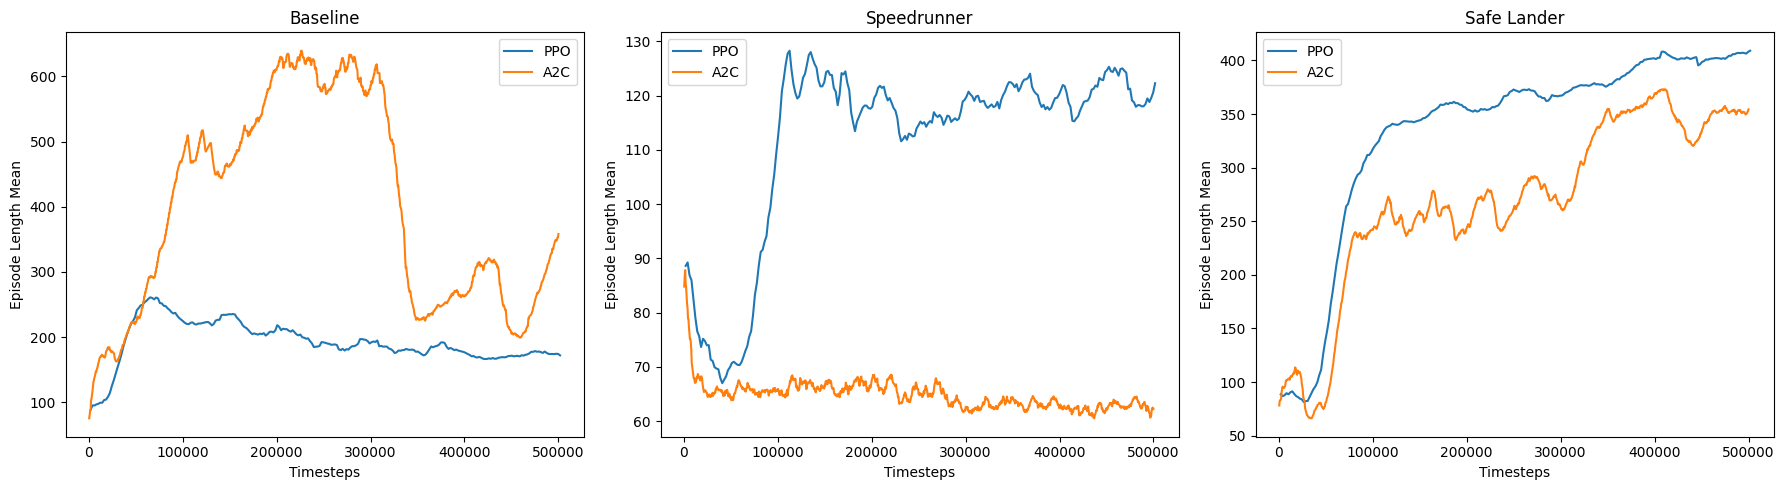

In [16]:
personas = ["baseline", "speedrunner", "safe"]
algos = ["ppo", "a2c"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, persona in enumerate(personas):
    for algo in algos:
        df = pd.read_csv(f"../data/lunar_lander/{algo}_{persona}_ep_len_mean.csv")
        axes[i].plot(df["Step"], df["Value"], label=algo.upper())
    
    if persona == "safe": 
        axes[i].set_title("Safe Lander")
    else: 
        axes[i].set_title(persona.capitalize())

    axes[i].set_xlabel("Timesteps")
    axes[i].set_ylabel("Episode Length Mean")
    axes[i].legend()
plt.tight_layout()
plt.show()

#### Analysis of Episode Length Curves
Above, we can see analyze a few things:
- **A2C Baseline** had longer episodes than PPO and the curve spikes much more. This is likely due to the agent spending more time hovering and failing trying to find out how to land. **PPO Baseline** also stabilized much quicker at around 100,000 timesteps, meaning it's more consistent and landing faster.
  
- **A2C Speedrunner** shows the same issue as earlier. It simply fails to learn because of the harsh reward design, and the curve stays flat. 

- **PPO Speedrunner** has the shortest episodes out of all other models.
  
- **Safe Lander** once again appears the most consistent for both algorithms. It is also clear that the episodes were the longest for this persona, which makes sense as it takes its time to land safely.

Overall, there is a noticeable difference between A2C and PPO algorithms for *Baseline* and *Speedrunner* personas. Since both of these reward designs are more volatile, the A2C models struggle to learn as they require a more stable learning environment. This is further proven by the *Safe Lander* persona. This reward design has smoother reward shaping and is much more stable, which allows the A2C model to learn consistently as well, though still not as good as PPO.

### 3. Performance Metrics
In this framework, after evaluating each model, CSV files of the per-episode metrics are automatically exported. Now, we will import these files and clean and aggregate the data to discover trends. The agents were evaluated on 30 episodes each, so the CSV files contain 30 rows of data.

#### Load Metrics CSV Files

In [17]:
# File paths for each agent's metrics
paths = {
    "PPO_Baseline": "../logs/lunar_lander/lunar_ppo_baseline_500000/metrics.csv",
    "PPO_Speedrunner": "../logs/lunar_lander/lunar_ppo_speedrunner_500000/metrics.csv",
    "PPO_SafeLander": "../logs/lunar_lander/lunar_ppo_safe_500000/metrics.csv",
    "A2C_Baseline": "../logs/lunar_lander/lunar_a2c_baseline_500000/metrics.csv",
    "A2C_Speedrunner": "../logs/lunar_lander/lunar_a2c_speedrunner_500000/metrics.csv",
    "A2C_SafeLander": "../logs/lunar_lander/lunar_a2c_safe_500000/metrics.csv",
}

# Load all CSV metrics into pandas dataframes
dfs = {name: pd.read_csv(path) for name, path in paths.items()}

#### Compute and Aggregate Metrics


In [21]:
metrics = []

for name, df in dfs.items(): 
    avg_reward = (df['total_reward'].mean()).round(1)
    landing_rate = (df['landed'].mean() * 100).round(1)
    perfect_landings = np.sum(df['landing_type'] == "perfect")
    crash_rate = (df['crashed'].mean() * 100).round(1)
    avg_landing_time = df['landing_time'].mean(skipna=True)

    metrics.append({
        "Agent": name,
        "Avg Reward": avg_reward,
        "Landing Rate (%)": landing_rate,
        "Perfect Landings": perfect_landings,
        "Crash Rate (%)": crash_rate,
        "Avg Landing Time": round(avg_landing_time, 1)
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Agent,Avg Reward,Landing Rate (%),Perfect Landings,Crash Rate (%),Avg Landing Time
0,PPO_Baseline,131.2,56.7,15,43.3,186.9
1,PPO_Speedrunner,95.7,46.7,10,53.3,130.7
2,PPO_SafeLander,59.2,80.0,24,16.7,429.8
3,A2C_Baseline,-11.7,16.7,5,83.3,353.2
4,A2C_Speedrunner,58.3,0.0,0,100.0,NaN
5,A2C_SafeLander,54.2,50.0,13,50.0,403.3


#### Metric Distributions
Now let's visualize the metrics above using Matplotlib so we can see the trends more clearly.

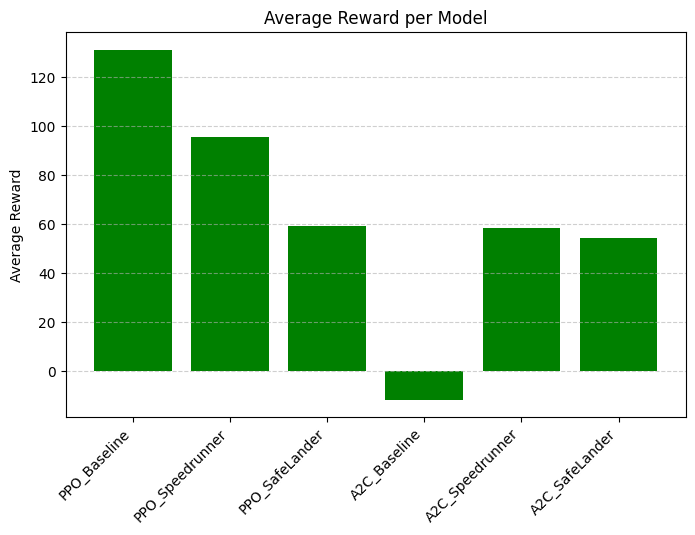

In [26]:
plt.figure(figsize=(8,5))
plt.bar(metrics_df["Agent"], metrics_df["Avg Reward"], color="green")
plt.title("Average Reward per Model")
plt.ylabel("Average Reward")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

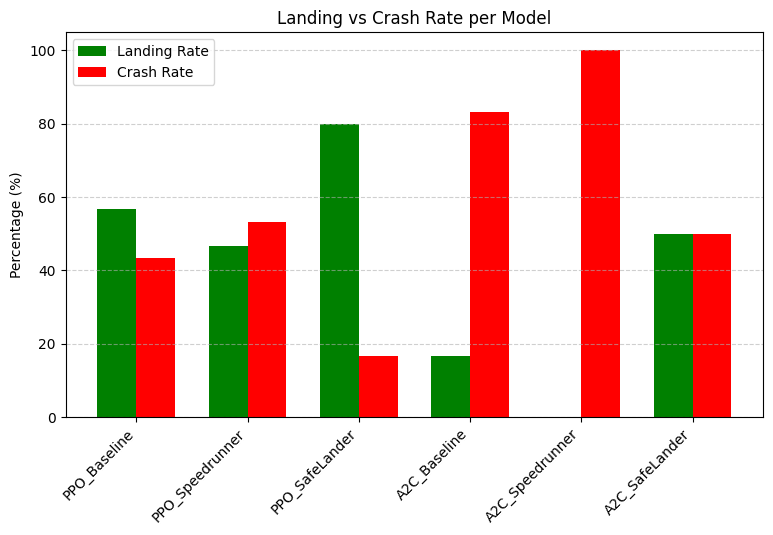

In [30]:
x = np.arange(len(metrics_df["Agent"]))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, metrics_df["Landing Rate (%)"], width, label="Landing Rate", color="green")
plt.bar(x + width/2, metrics_df["Crash Rate (%)"], width, label="Crash Rate", color="red")

plt.title("Landing vs Crash Rate per Model")
plt.ylabel("Percentage (%)")
plt.xticks(x, metrics_df["Agent"], rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

#### Analysis of Performance Metrics
- **PPO Baseline** achieved the highest average reward across 30 episodes, while **A2C Baseline** had the lowest. This shows how switching from PPO to A2C algorithm can drastically reduce performance, meaning PPO has better learning efficiency and stability.

- **A2C Speedrunner** was the least successful model in terms of crashes, it had a 100% crash rate and failed to learn how to land. Despite that, it ended up with the highest reward of the other A2C models. This shows how the A2C algorithm prioritizes getting the highest reward, ignoring learning behaviour. It simply found a local optimum where it was maximizing rewards, while still crashing every time.

- **Safe Lander** achieved the highest landing rate across both algorithms, which aligns with its reward design. Additionally, it also had the longest average landing times. The model prioritizes landing safely, steadily, and accurately. These metrics clearly reflect its intended behaviour.

- Conversely, **PPO Speedrunner** had the shortest average landing time, as expected due to its reward design prioritizing speed at the cost of more frequent crashes.

These results clearly demonstrate how different learning algorithms and reward designs impact agent behaviour and performance.